## File used to analyse the Japanese dataset in terms of EDES parameters

In [1]:
using CSV
using DataFrames

# Load the OGTT data
data_OGTT = CSV.read("C:/Users/20192809/Documents/Data/ohashi_csv_files/ohashi_OGTT.csv", DataFrame)

# load the subject data
data_subject = CSV.read("C:/Users/20192809/Documents/Data/ohashi_csv_files/ohashi_subjectinfo.csv", DataFrame);

In [3]:
data_NGT_info

Row,No,sex(male1),age,BH,BW,BMI,type
,Int64,Int64,Int64,Float64,Float64,Float64,String7
1,1,0,34,152.1,78.7,34.0,NGT
2,2,1,34,172.9,98.7,33.0,NGT
3,3,1,44,172.0,70.0,23.7,NGT
4,4,1,35,172.0,60.0,20.3,NGT
5,5,1,41,183.0,74.0,22.1,NGT
6,6,1,30,178.8,66.8,20.9,NGT
7,7,0,41,163.0,58.0,21.8,NGT
8,8,1,60,170.3,65.0,22.4,NGT
9,9,1,22,173.0,65.0,21.7,NGT


### select the OGTT data from the normal glucose tolerant subjects

In [2]:
data_NGT_info = data_subject[data_subject[!, :type] .== "NGT", :]

# Extract the list of IDs from the NGT data
ngt_ids = data_NGT_info[!, :No]

# Filter the OGTT data for rows where the ID matches an NGT ID
data_NGT_OGTT = data_OGTT[in.(data_OGTT[!, :No], Ref(ngt_ids)), :]

# convert glucose values to mmol/L
data_NGT_OGTT[!, 2:6] = data_NGT_OGTT[!, 2:6] ./ 18

# add bodyweight to OGTT data
data_NGT_OGTT = rightjoin(data_NGT_OGTT, data_NGT_info[:, [:No, :BW]], on = :No)

# drop individuals with missing values
data_NGT_OGTT = dropmissing(data_NGT_OGTT)


# extract data from the OGTT data
glucose =Matrix(data_NGT_OGTT[!, 2:6])
insulin = Matrix(data_NGT_OGTT[!, 7:11])
bodyweight = data_NGT_OGTT[!, :BW]
G_dose = 75000
time_G = [0, 30, 60, 90, 120]
time_I = [0, 30, 60, 90, 120];


## Fit the EDES model to the data and calculate the EDES parameters    

In [26]:
# fitting hyperparameters
parameters_to_fit = ["k1","k5", "k6"]#, "k8"]
ub = [0.5, 1.5, 10.]#, 20.]#0.5
lb =  [0.0005, 0, 0.5]#, 0.]# 0.0005
save_file = false

In [40]:
using Distributed

n_cores = length(Sys.cpu_info())

if nprocs()-1 < n_cores
    addprocs(n_cores-nprocs()+1, exeflags="--project")
end

@everywhere begin
    using DifferentialEquations, SciMLBase, Random # for solving ODEs
    using DataFrames
    using Optimization, OptimizationOptimJL, LineSearches # for optimization
    using QuasiMonteCarlo # for LHS
    using Trapz
    include("../EDES/including.jl")
end


# extract data from the OGTT data
glucose =Matrix(data_NGT_OGTT[!, 2:6])
insulin = Matrix(data_NGT_OGTT[!, 7:11])
bodyweight = data_NGT_OGTT[!, :BW]
G_dose = 75000
time_G = [0, 30, 60, 90, 120]
time_I = [0, 30, 60, 90, 120]

# Prepare the patients list with positional and keyword arguments as a tuple
patients = [
    (glucose[i, :], insulin[i, :], bodyweight[i], G_dose, time_G, time_I, 
    (parameters_to_fit, ub, lb, save_file)) 
    for i in 1:size(glucose, 1)
]

# Wrapper function to pass keyword arguments correctly
@everywhere function wrapper(params)
    glucose, insulin, BW, meal_G, time_G, time_I, (estimated_params, ub, lb, save_boolean) = params
    ParameterEstimation(
        glucose,
        insulin,
        BW,
        meal_G,
        time_G,
        time_I;
        estimated_params = estimated_params,
        ub = ub,
        lb = lb,
        save_boolean = save_boolean
    )
end

# Use pmap with the wrapper
results = pmap(x -> wrapper(x), patients)

# close the parallel pool

rmprocs(procs()[2:end])


      From worker 35:	Optimization successful! continuing...
      From worker 35:	Parameter estimation done!
      From worker 36:	Optimization successful! continuing...
      From worker 36:	Parameter estimation done!
      From worker 42:	Optimization successful! continuing...
      From worker 42:	Parameter estimation done!
      From worker 41:	Optimization successful! continuing...
      From worker 41:	Parameter estimation done!
      From worker 38:	Optimization successful! continuing...
      From worker 38:	Parameter estimation done!
      From worker 35:	Optimization successful! continuing...
      From worker 35:	Parameter estimation done!
      From worker 37:	Optimization successful! continuing...
      From worker 37:	Parameter estimation done!
      From worker 39:	Optimization successful! continuing...
      From worker 39:	Parameter estimation done!
      From worker 36:	Optimization successful! continuing...
      From worker 36:	Parameter estimation done!
      From

Task (done) @0x0000026f3aebcda0

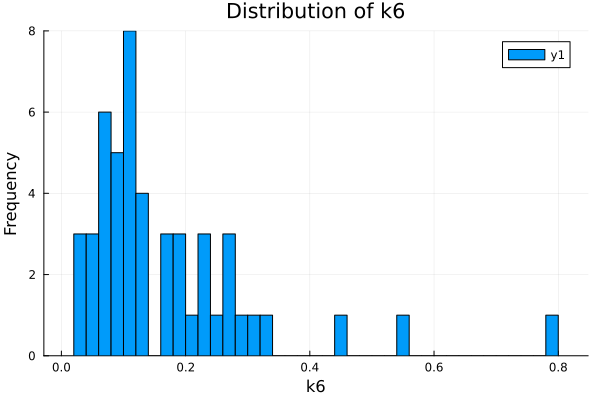

In [42]:
using Statistics

df_k1 = DataFrame(k1 = [results[i][1] for i in 1:length(results)])
df_k5 = DataFrame(k5 = [results[i][2] for i in 1:length(results)])
df_k6 = DataFrame(k6 = [results[i][3] for i in 1:length(results)])

# get statistics of df
# describe(df_k1)

describe(df_k6)

describe(df_k5)
# create a plot 
using Plots
histogram(df_k5.k5, bins=50, title="Distribution of k6", xlabel="k6", ylabel="Frequency")

In [46]:
describe(df_k5)
# describe(df_k6)
# df_k6

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,k5,0.169861,0.0332863,0.119896,0.798424,0,Float64


## visually inspect the fits

In [47]:
using GLMakie

include("./Help functions/PlotAnalysis.jl")

results_df = hcat(df_k1,df_k5, df_k6)

data_NGT_OGTT
time_G = [0, 30, 60, 90, 120]
time_I = [0, 30, 60, 90, 120]
G_dose = 75000

glucose = Matrix(data_NGT_OGTT[!, 2:6])
insulin = Matrix(data_NGT_OGTT[!, 7:11])
BW = data_NGT_OGTT[!, :BW]

accepted = Interactive_plots_EDES(results_df, glucose, insulin, BW, time_G, time_I, G_dose = G_dose)

49-element Vector{Bool}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [74]:
# Filter the results_df dataframe to include only the accepted ones
accepted_df = results_df[accepted .== 1, :]

# Display the accepted dataframe
accepted_df
describe(accepted_df[!,3])
# save the accepted_df to a csv file
# CSV.write("./accepted_df.csv", accepted_df)


Summary Stats:
Length:         25
Missing Count:  0
Mean:           1.852746
Std. Deviation: 0.940347
Minimum:        0.500000
1st Quartile:   1.150403
Median:         1.708342
3rd Quartile:   2.624589
Maximum:        3.770402
Type:           Float64


In [68]:
include("../EDES/including.jl")

PlotMealResponse (generic function with 9 methods)

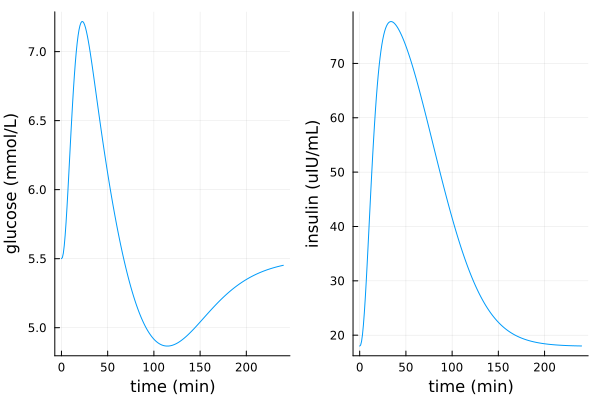

In [69]:
# get parameter values for the accepted patients
accepted_k1 = accepted_df[!, 1]
accepted_k5 = accepted_df[!, 2]
accepted_k6 = accepted_df[!, 3]

# get the mean of the accepted parameters
mean_k1 = mean(accepted_k1)
mean_k5 = mean(accepted_k5)
mean_k6 = mean(accepted_k6)
estimated_parameter_values = [mean_k1, mean_k5, mean_k6]

# simulate someone with the mean parameters
edes_model = EDES()
PlotMealResponse(edes_model,estimated_parameter_values )
# simulate the OGTT




